In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **RESIZING THE IMAGES**

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
import time

def resize_images_in_batches(input_dir, output_dir, target_size=(1920, 1080), batch_size=100, max_retries=5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    total_batches = len(files) // batch_size + (1 if len(files) % batch_size != 0 else 0)

    for batch_num in range(total_batches):
        batch_files = files[batch_num * batch_size:(batch_num + 1) * batch_size]
        print(f"Processing batch {batch_num + 1}/{total_batches} with {len(batch_files)} files")
        for filename in tqdm(batch_files, desc=f"Batch {batch_num + 1}/{total_batches}"):
            img_path = os.path.join(input_dir, filename)
            retries = 0
            while retries < max_retries:
                try:
                    img = Image.open(img_path)
                    img_resized = img.resize(target_size, Image.LANCZOS)
                    img_resized.save(os.path.join(output_dir, filename))
                    break
                except OSError as e:
                    retries += 1
                    print(f"Error processing {img_path}: {e}, retrying {retries}/{max_retries}")
                    time.sleep(1)
                    if retries == max_retries:
                        print(f"Failed to process {img_path} after {max_retries} retries")
                except Exception as e:
                    print(f"An unexpected error occurred with {img_path}: {e}")
                    break

input_dir = '/content/drive/MyDrive/x'
output_dir = '/content/drive/My Drive/project_folder/output_images/1080pimg'
resize_images_in_batches(input_dir, output_dir)


# **PIXELATING THE IMAGE**

In [ ]:
import os
from PIL import Image

def resize_and_save_images(input_dir, output_dir_non_pixelated, target_size=(1920, 1080)):
    if not os.path.exists(output_dir_non_pixelated):
        os.makedirs(output_dir_non_pixelated)

    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)

        if img.size == target_size:
            img.save(os.path.join(output_dir_non_pixelated, filename))
        else:
            img = img.resize(target_size, Image.ANTIALIAS)
            img.save(os.path.join(output_dir_non_pixelated, filename))

input_dir = ''
output_dir_non_pixelated = ''
resize_and_save_images(input_dir, output_dir_non_pixelated)

# **TRAINING THE MODEL(DETECTION)**

Found 3744 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
117/117 [==============================] - 619s 5s/step - loss: 0.7726 - accuracy: 0.5938 - val_loss: 0.6153 - val_accuracy: 0.6357 - lr: 1.0000e-04
Epoch 2/10
117/117 [==============================] - 563s 5s/step - loss: 0.6222 - accuracy: 0.6589 - val_loss: 0.5722 - val_accuracy: 0.7244 - lr: 1.0000e-04
Epoch 3/10
117/117 [==============================] - 564s 5s/step - loss: 0.5824 - accuracy: 0.6958 - val_loss: 0.5247 - val_accuracy: 0.7489 - lr: 1.0000e-04
Epoch 4/10
117/117 [==============================] - 506s 4s/step - loss: 0.5554 - accuracy: 0.7222 - val_loss: 0.5219 - val_accuracy: 0.7350 - lr: 1.0000e-04
Epoch 5/10
117/117 [==============================] - 564s 5s/step - loss: 0.5418 - accuracy: 0.7228 - val_loss: 0.5208 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 6/10
117/117 [==============================] - 

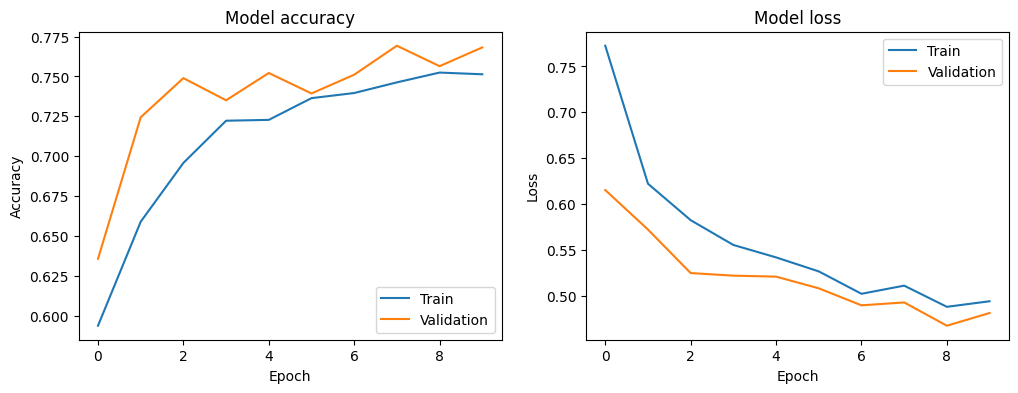

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/finaldata',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/finaldata',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(2)}

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

model.save('/content/drive/My Drive/finaldata/detection2.keras')

y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model loss')
plt.show()


# **TRAINING THE MODEL(CORRECTION)**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, Add, UpSampling2D
from tensorflow.keras.models import Model
import os

def load_images(image_dir):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

high_res_images = load_images('/content/drive/MyDrive/finaldata/class_0')
low_res_images = load_images('/content/drive/MyDrive/finaldata/class_1')

input_img = Input(shape=(224, 224, 3))
c1 = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
c2 = Conv2D(32, (1, 1), activation='relu', padding='same')(c1)
c3 = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(c2)

correction_model = Model(inputs=input_img, outputs=c3)
correction_model.compile(optimizer='adam', loss='mean_squared_error')

correction_model.fit(low_res_images, high_res_images, epochs=20, batch_size=16, validation_split=0.2)

correction_model.save('/content/drive/My Drive/project_folder/correction_model.h5')


Epoch 1/20
117/117 [==============================] - 640s 5s/step - loss: 0.0843 - val_loss: 0.0880
Epoch 2/20
117/117 [==============================] - 640s 5s/step - loss: 0.0825 - val_loss: 0.0879
Epoch 3/20
117/117 [==============================] - 637s 5s/step - loss: 0.0824 - val_loss: 0.0883
Epoch 4/20
117/117 [==============================] - 637s 5s/step - loss: 0.0822 - val_loss: 0.0875
Epoch 5/20
117/117 [==============================] - 628s 5s/step - loss: 0.0823 - val_loss: 0.0882
Epoch 6/20
117/117 [==============================] - 626s 5s/step - loss: 0.0821 - val_loss: 0.0870
Epoch 7/20
117/117 [==============================] - 625s 5s/step - loss: 0.0821 - val_loss: 0.0882
Epoch 8/20
117/117 [==============================] - 635s 5s/step - loss: 0.0821 - val_loss: 0.0868
Epoch 9/20
117/117 [==============================] - 615s 5s/step - loss: 0.0822 - val_loss: 0.0873
Epoch 10/20
117/117 [==============================] - 617s 5s/step - loss: 0.0822 - val_lo

# **Detect and Correct Pixelated Images**

In [ ]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import os

detection_model = load_model('/content/drive/My Drive/finaldata/detection2.keras')
correction_model = load_model('/content/drive/My Drive/project_folder/correction.h5')

def detect_and_correct(input_dir, output_dir, detection_model, correction_model):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        img = Image.open(img_path)
        img_resized = img.resize((224, 224), Image.LANCZOS)
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        is_pixelated = detection_model.predict(img_array)[0][0] > 0.5
        if is_pixelated:
            corrected_img_array = correction_model.predict(img_array)[0]
            corrected_img_array = (corrected_img_array * 255).astype(np.uint8)
            corrected_img = Image.fromarray(corrected_img_array)
            corrected_img = corrected_img.resize((1920, 1080), Image.LANCZOS)
            corrected_img.save(os.path.join(output_dir, filename))
        else:
            img.save(os.path.join(output_dir, filename))

output_dir_corrected = '/content/drive/MyDrive/project_folder/corrected'
detect_and_correct('/content/drive/MyDrive/finaldata/class_1', output_dir_corrected, detection_model, correction_model)


1/1 [==============================] - 0s 77ms/step
